In [1]:
import torch
import torchvision
from pathlib import Path
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
data_path= Path("Food/")
image_path= data_path/"pizza_steak_sushi"

train_dir=image_path/'train'
test_dir=image_path/'test'

In [3]:
data_path, image_path, train_dir, test_dir

(WindowsPath('Food'),
 WindowsPath('Food/pizza_steak_sushi'),
 WindowsPath('Food/pizza_steak_sushi/train'),
 WindowsPath('Food/pizza_steak_sushi/test'))

In [4]:
train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.RandomHorizontalFlip(p=0.1),
                                      transforms.RandomRotation(degrees=15),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.2),
                                      transforms.ToTensor(),
                                     ])

test_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor(),
                                    ])

In [5]:
train_transform, test_transform

(Compose(
     Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.1)
     RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.9, 1.1), contrast=(0.8, 1.2), saturation=None, hue=None)
     ToTensor()
 ),
 Compose(
     Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [6]:
train_dataset = datasets.ImageFolder(root=train_dir,
                                     transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir,
                                    transform=test_transform)

train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         num_workers=4)

print(f"Train dataset: {len(train_dataset)} images")
print(f"Test dataset: {len(test_dataset)} images")
print(f"Classes: {train_dataset.classes}")

Train dataset: 225 images
Test dataset: 80 images
Classes: ['pizza', 'steak', 'sushi']


In [7]:
len(train_loader), len(test_loader)

(8, 3)

In [8]:
img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [9]:
class ImprovedVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, output_shape)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedVGG(input_shape=3,
                    hidden_units=64,
                    output_shape=len(train_dataset.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [11]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (y_pred.argmax(1) == y).sum().item()

    return train_loss / len(dataloader), train_correct / len(dataloader.dataset)

In [12]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            test_correct += (y_pred.argmax(1) == y).sum().item()

    return test_loss / len(dataloader), test_correct / len(dataloader.dataset)

In [13]:
epochs = 10
for epoch in range(epochs):
    train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_loader, loss_fn, device)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Epoch 1 | Train Loss: 1.7268 | Train Acc: 0.3422 | Test Loss: 1.2477 | Test Acc: 0.3625
Epoch 2 | Train Loss: 1.0898 | Train Acc: 0.3911 | Test Loss: 1.1230 | Test Acc: 0.3500
Epoch 3 | Train Loss: 1.0068 | Train Acc: 0.4000 | Test Loss: 0.9755 | Test Acc: 0.4625
Epoch 4 | Train Loss: 0.9289 | Train Acc: 0.5111 | Test Loss: 1.0990 | Test Acc: 0.4250
Epoch 5 | Train Loss: 0.9513 | Train Acc: 0.5333 | Test Loss: 1.0251 | Test Acc: 0.4500
Epoch 6 | Train Loss: 0.9259 | Train Acc: 0.6222 | Test Loss: 1.1738 | Test Acc: 0.4125
Epoch 7 | Train Loss: 0.8662 | Train Acc: 0.5689 | Test Loss: 0.9276 | Test Acc: 0.4625
Epoch 8 | Train Loss: 0.9700 | Train Acc: 0.4978 | Test Loss: 1.0034 | Test Acc: 0.4125
Epoch 9 | Train Loss: 0.9110 | Train Acc: 0.5067 | Test Loss: 0.9458 | Test Acc: 0.4625
Epoch 10 | Train Loss: 0.9142 | Train Acc: 0.5644 | Test Loss: 1.0712 | Test Acc: 0.4125


Using device: cpu
Epoch 1 | Train Loss: 2.0747 | Train Acc: 0.3906 | Test Loss: 1.4593 | Test Acc: 0.2917
Epoch 2 | Train Loss: 1.2370 | Train Acc: 0.3164 | Test Loss: 1.1698 | Test Acc: 0.3021
Epoch 3 | Train Loss: 1.0940 | Train Acc: 0.3320 | Test Loss: 1.0415 | Test Acc: 0.5729
Epoch 4 | Train Loss: 1.1078 | Train Acc: 0.3320 | Test Loss: 1.1292 | Test Acc: 0.3854
Epoch 5 | Train Loss: 1.0551 | Train Acc: 0.3633 | Test Loss: 0.9957 | Test Acc: 0.5417
Epoch 6 | Train Loss: 0.9364 | Train Acc: 0.6016 | Test Loss: 1.0151 | Test Acc: 0.5312
Epoch 7 | Train Loss: 0.9322 | Train Acc: 0.5000 | Test Loss: 0.9429 | Test Acc: 0.4583
Epoch 8 | Train Loss: 0.8282 | Train Acc: 0.6641 | Test Loss: 0.9826 | Test Acc: 0.4062
Epoch 9 | Train Loss: 0.8018 | Train Acc: 0.6367 | Test Loss: 1.4934 | Test Acc: 0.3333
Epoch 10 | Train Loss: 1.0103 | Train Acc: 0.5039 | Test Loss: 0.9942 | Test Acc: 0.3646


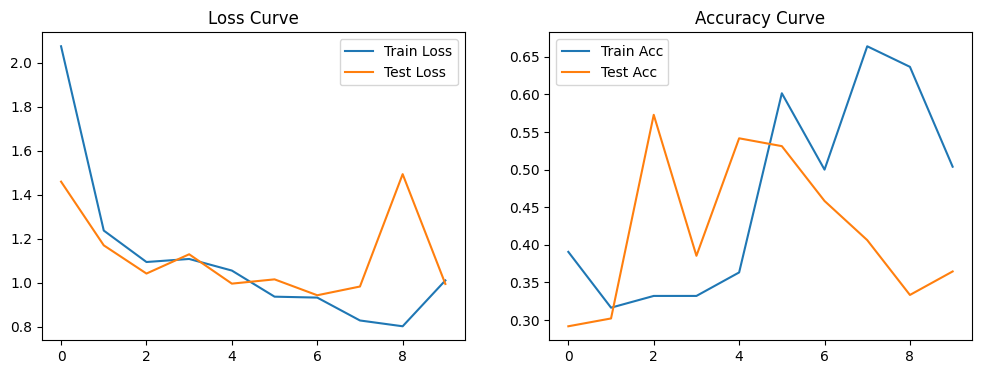

In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from pathlib import Path

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set Paths
data_path = Path("Food/")
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Resize((128, 128)),  
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor()
])

# Load Data
train_data = ImageFolder(root=train_dir, transform=train_transforms)
test_data = ImageFolder(root=test_dir, transform=test_transforms)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define Updated ImprovedVGG Model
class ImprovedVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 2, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 31 * 31, 512)
        self.fc2 = nn.Linear(512, output_shape)
        self.dropout = nn.Dropout(0.5)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Model Setup
torch.manual_seed(42)
model = ImprovedVGG(input_shape=3, hidden_units=64, output_shape=len(train_data.classes)).to(device)

# Loss Function & Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

# Training & Testing Functions
def train_step(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y)

    return train_loss / len(dataloader), train_acc / len(dataloader)

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            test_loss += loss.item()
            test_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y)

    return test_loss / len(dataloader), test_acc / len(dataloader)

# Training Loop
epochs = 6
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# Plot Accuracy & Loss
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(range(epochs), train_losses, label="Train Loss")
axs[0].plot(range(epochs), test_losses, label="Test Loss")
axs[0].set_title("Loss Curve")
axs[0].legend()

axs[1].plot(range(epochs), train_accuracies, label="Train Acc")
axs[1].plot(range(epochs), test_accuracies, label="Test Acc")
axs[1].set_title("Accuracy Curve")
axs[1].legend()

plt.show()


In [15]:
# torch.save(model.state_dict(), "food101_vgg.pth")  # Save trained model

# # Load model for evaluation
# model.load_state_dict(torch.load("food101_vgg.pth"))
# model.to(device)

# test_loss, test_acc = test_step(model, test_loader, loss_fn, device)
# print(f"Final Test Accuracy: {test_acc * 100:.2f}%")


# Improved model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
data_path = Path("Food/")
image_path = data_path / "pizza_steak_sushi"

train_dir = image_path / "train"
test_dir = image_path / "test"

In [32]:
train_dir, test_dir

(WindowsPath('Food/pizza_steak_sushi/train'),
 WindowsPath('Food/pizza_steak_sushi/test'))

In [23]:
# Data Augmentation
train_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.ToTensor()
                                      ])

test_transforms = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.ToTensor()
                                     ])

In [31]:
train_transforms, test_transforms

(Compose(
     Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
     ToTensor()
 ),
 Compose(
     Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
 ))

In [25]:
#Load Dataset
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transforms)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transforms)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: Food\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 80
     Root location: Food\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [26]:
train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                             batch_size=32,
                             shuffle=False)
test_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x211cdf92750>,
 <torch.utils.data.dataloader.DataLoader at 0x211cdf92750>)

In [29]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [33]:
class ImprovedVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(hidden_units),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=0),
                                          nn.BatchNorm2d(hidden_units),
                                          nn.LeakyReLU(0.1),
                                          nn.MaxPool2d(kernel_size=2)
                                         )

        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units * 2, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(hidden_units * 2),
                                          nn.ReLU(),
                                          nn.Conv2d(in_channels=hidden_units * 2, out_channels=hidden_units * 2, kernel_size=3, padding=1),
                                          nn.BatchNorm2d(hidden_units * 2),
                                          nn.LeakyReLU(0.1),
                                          nn.MaxPool2d(kernel_size=2)
                                         )

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(31 * 31 * hidden_units * 2, 512)
        self.fc2 = nn.Linear(512, output_shape)
        
        self.dropout = nn.Dropout(0.6)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [34]:
torch.manual_seed(42)
model = ImprovedVGG(input_shape=3, hidden_units=64, output_shape=len(train_data.classes))
model.to(device)

ImprovedVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

In [40]:
loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.001
 ))

In [ ]:
def train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0
        
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()
        
        train_loss /= len(train_dataloader)
        train_acc = train_correct / len(train_data)
        
        # Validation Phase
        model.eval()
        test_loss, test_correct = 0, 0
        
        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                test_loss += loss.item()
                test_correct += (outputs.argmax(1) == labels).sum().item()
        
        test_loss /= len(test_dataloader)
        test_acc = test_correct / len(test_data)
        
        scheduler.step(test_loss)
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs=6)

Epoch 1 | Train Loss: 3.9729 | Train Acc: 0.6622 | Test Loss: 4.6120 | Test Acc: 0.5625
Epoch 2 | Train Loss: 4.7164 | Train Acc: 0.6444 | Test Loss: 4.6681 | Test Acc: 0.5875


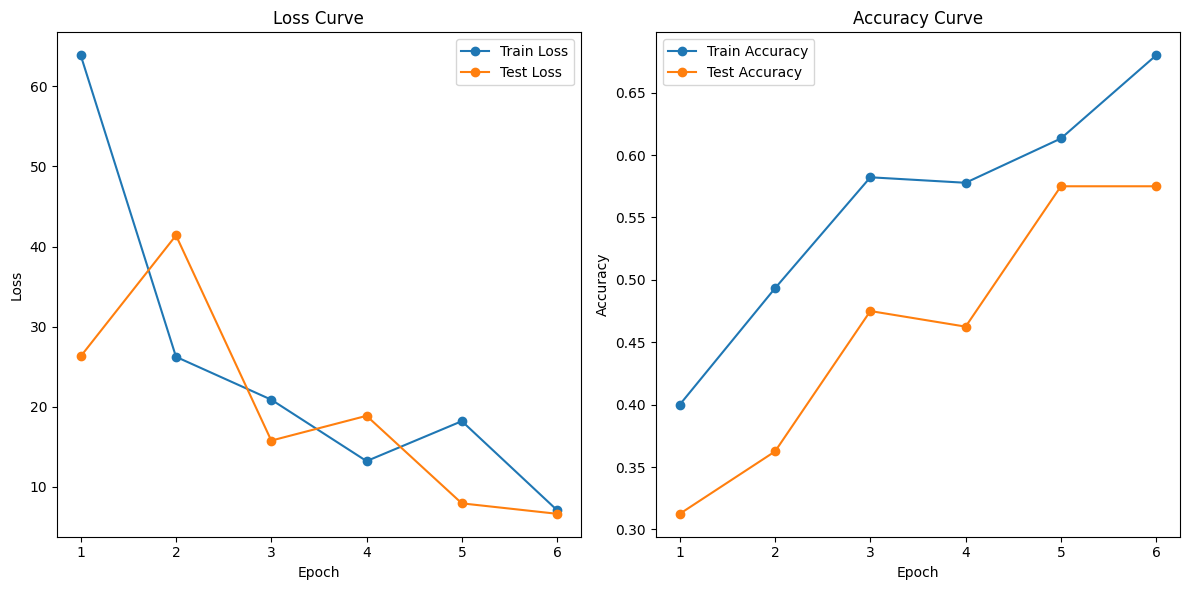

Training completed!


In [48]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='o')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy', marker='o')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

print("Training completed!")